In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
import random
import io
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

## Load Data

In [2]:
user_df = pd.read_csv('User_db.csv')
user_df.head()

,User_ID,ID,Brand,Category,Gender,Name,Image URL,Price,Customer_Cluster,Shop_Cluster
0,1,33.0,Adidas,Jackets & Coats,Mens,CNY JACKET,http://img.adidas.com.hk/resources/2020/12/29/...,999.0,3.0,1.0
1,1,36.0,Adidas,Jumpers,Mens,ESSENTIALS EMBROIDERED SMALL LOGO SWEATSHIRT,http://img.adidas.com.hk/resources/2020/12/28/...,299.0,3.0,1.0
2,1,35.0,Adidas,Polos,Mens,ADIPURE PREMIUM ENGINEERED POLO SHIRT,http://img.adidas.com.hk/resources/2020/8/27/1...,780.0,3.0,1.0
3,1,55.0,Adidas,Shorts,Mens,MANCHESTER UNITED 20/21 AWAY SHORTS,http://img.adidas.com.hk/resources/2020/8/14/1...,369.0,3.0,1.0
4,1,53.0,Adidas,T-Shirts,Mens,GERMANY HOME JERSEY,http://img.adidas.com.hk/resources/2019/10/29/...,599.0,3.0,1.0


In [3]:
#Load Customer profiles
customer_profiles = pd.read_csv('Customer_Profiles.csv')
customer_profiles.set_index('Customer_Cluster', inplace = True)
customer_profiles = customer_profiles.loc[:, ~customer_profiles.columns.str.contains('^Unnamed')]
customer_profiles.head()

,Gender,Style,Blouses,Dresses,Jackets & Coats,Jeans,Jumpers,Polos,Shirts,Shorts,Skirts,Suits,Trousers,T-Shirts
Customer_Cluster,,,,,,,,,,,,,,
1.0,Mens,Casual,0.0,0.0,0.1,0.20,0.10,0.10,0.00,0.20,0.0,0.0,0.00,0.30
2.0,Mens,Casual,0.0,0.0,0.2,0.15,0.15,0.00,0.05,0.10,0.0,0.0,0.00,0.35
3.0,Mens,Casual,0.0,0.0,0.1,0.20,0.15,0.20,0.05,0.10,0.0,0.0,0.00,0.20
4.0,Mens,Casual,0.0,0.0,0.2,0.00,0.10,0.15,0.10,0.15,0.0,0.0,0.15,0.15
5.0,Mens,Casual,0.0,0.0,0.0,0.25,0.00,0.20,0.00,0.20,0.0,0.0,0.00,0.35


In [4]:
#Load Shop Profiles
shop_profiles = pd.read_csv('Shop_Profiles.csv')
shop_profiles.set_index('Shop_Cluster', inplace = True)
shop_profiles = shop_profiles.loc[:, ~shop_profiles.columns.str.contains('^Unnamed')]
shop_profiles.head()

,Gender,Style,Adidas,CalvinKleinMen,CalvinKleinPerformance,CalvinKleinWomen,Max&Co,MaxMara,Muji,Nike,Brooks Brothers,Boss,Fred Perry,Saint Laurent,Uniqlo,Moncler,Ralph_Lauren
Shop_Cluster,,,,,,,,,,,,,,,,,
1,Mens,Casual,0.1,0.15,0.1,0.00,0.0,0.00,0.10,0.15,0.0,0.0,0.1,0.05,0.15,0.0,0.1
2,Womens,Casual,0.1,0.00,0.1,0.15,0.1,0.00,0.10,0.10,0.0,0.0,0.1,0.00,0.15,0.0,0.1
3,Mens,Casual,0.1,0.15,0.1,0.00,0.0,0.00,0.15,0.05,0.1,0.0,0.1,0.05,0.20,0.0,0.0
4,Womens,Casual,0.1,0.00,0.1,0.15,0.1,0.15,0.10,0.00,0.0,0.0,0.1,0.00,0.20,0.0,0.0
5,Mens,Smart,0.0,0.10,0.0,0.00,0.0,0.00,0.00,0.00,0.2,0.1,0.1,0.10,0.00,0.2,0.2


In [5]:
#Load Product db
products = pd.read_csv('AllCombined.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.head()

,ID,Brand,Category,Gender,Name,Image URL,Price
0,1.0,Adidas,T-Shirts,Mens,HUMAN MADE GRAPHIC TEE,http://img.adidas.com.hk/resources/2021/4/13/1...,699
1,2.0,Adidas,T-Shirts,Mens,TREFOIL GRAPHIC PACK SHORT SLEEVE TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,499
2,3.0,Adidas,T-Shirts,Mens,HEAT.RDY RUNNING TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,329
3,4.0,Adidas,T-Shirts,Mens,DAME AVATAR POCKET TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,269
4,5.0,Adidas,T-Shirts,Mens,ADICOLOR PREMIUM TEE (GENDER NEUTRAL),http://img.adidas.com.hk/resources/2021/3/30/1...,399


## Calculate User Brand/Category profiles

In [6]:
def create_user_shop_profile(user_df):
    #Create empty user_shop_profile df
    user_shop_profile = pd.DataFrame(columns = shop_profiles.columns[2:])
    user_shop_profile.insert(0, 'User_id',0)
    user_shop_profile.set_index(['User_id'], inplace = True)
    #Loop through users, calculate shop weights, append to user_shop_profile df
    for user_id in user_df['User_ID'].unique():
        subset = user_df[user_df['User_ID'] == user_id]
        shop_weights = subset['Brand'].value_counts()/sum(subset['Brand'].value_counts())
        user_weights = np.zeros(shape = 0)
        for brand in user_shop_profile.columns:
            try:
                user_weights = np.append(user_weights, shop_weights[brand])
            except:
                user_weights = np.append(user_weights, 0)
                pass
        user_shop_profile.loc[user_id] = user_weights
    return user_shop_profile

In [7]:
def create_user_product_profile(user_df):
    #Create empty user_shop_profile df
    user_product_profile = pd.DataFrame(columns = customer_profiles.columns[2:])
    user_product_profile.insert(0, 'User_id',0)
    user_product_profile.set_index(['User_id'], inplace = True)
    #Loop through users, calculate shop weights, append to user_shop_profile df
    for user_id in user_df['User_ID'].unique():
        subset = user_df[user_df['User_ID'] == user_id]
        product_weights = subset['Category'].value_counts()/sum(subset['Category'].value_counts())
        user_weights = np.zeros(shape = 0)
        for brand in user_product_profile.columns:
            try:
                user_weights = np.append(user_weights, product_weights[brand])
            except:
                user_weights = np.append(user_weights, 0)
                pass
        user_product_profile.loc[user_id] = user_weights
    return user_product_profile

In [8]:
#Calculate user_shop_profile
user_shop_profile = create_user_shop_profile(user_df)
#Calculate user_product_profile
user_product_profile = create_user_product_profile(user_df)

#Combine shop and product profiles into 1 df
# This will be used in the distance matrix calculation
user_both_profile = pd.concat([user_shop_profile, user_product_profile], axis = 1)
user_both_profile

,Adidas,CalvinKleinMen,CalvinKleinPerformance,CalvinKleinWomen,Max&Co,MaxMara,Muji,Nike,Brooks Brothers,Boss,...,Jackets & Coats,Jeans,Jumpers,Polos,Shirts,Shorts,Skirts,Suits,Trousers,T-Shirts
User_id,,,,,,,,,,,,,,,,,,,,,
1,0.138889,0.166667,0.111111,0.000000,0.000000,0.000000,0.055556,0.138889,0.000000,0.0,...,0.166667,0.111111,0.166667,0.138889,0.000000,0.138889,0.000000,0.000000,0.000000,0.277778
2,0.136364,0.159091,0.090909,0.000000,0.000000,0.000000,0.090909,0.159091,0.000000,0.0,...,0.295455,0.000000,0.136364,0.090909,0.090909,0.113636,0.000000,0.000000,0.136364,0.136364
3,0.000000,0.000000,0.000000,0.234043,0.297872,0.234043,0.000000,0.000000,0.000000,0.0,...,0.212766,0.000000,0.000000,0.000000,0.000000,0.000000,0.255319,0.000000,0.212766,0.000000
4,0.000000,0.000000,0.000000,0.222222,0.370370,0.185185,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.259259,0.000000,0.259259,0.000000
5,0.000000,0.000000,0.000000,0.166667,0.333333,0.250000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.250000,0.000000,0.208333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.232143,0.000000,0.160714,0.160714,0.000000,0.000000,0.035714,0.250000,0.000000,0.0,...,0.000000,0.035714,0.339286,0.035714,0.000000,0.178571,0.000000,0.000000,0.000000,0.410714
191,0.000000,0.000000,0.000000,0.266667,0.066667,0.133333,0.000000,0.000000,0.000000,0.0,...,0.000000,0.133333,0.200000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.200000
192,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.181818,0.0,...,0.000000,0.000000,0.272727,0.000000,0.272727,0.000000,0.000000,0.181818,0.272727,0.000000


## Calculate Distance Matrix

In [9]:
#Calculate distance matrix for products and shops
input_df = user_both_profile
distance_matrix = pd.DataFrame(
    squareform(pdist(input_df)),
    columns = input_df.index,
    index = input_df.index)
distance_matrix

User_id,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
User_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.288299,0.794358,0.866718,0.854138,0.770403,0.448952,0.953389,0.209772,0.818068,...,0.531783,0.457289,0.848614,1.284403,0.986209,0.440271,0.712888,0.736379,0.122136,0.773181
2,0.288299,0.000000,0.720491,0.819584,0.816127,0.696211,0.479011,0.892076,0.316042,0.751628,...,0.470094,0.598457,0.744121,1.276375,0.948166,0.579402,0.767023,0.668815,0.343381,0.643627
3,0.794358,0.720491,0.000000,0.281561,0.273303,0.849608,0.777169,0.964004,0.824263,0.123659,...,0.570403,0.927007,0.857453,1.202928,0.408797,0.935180,0.828162,0.842617,0.823389,0.788053
4,0.866718,0.819584,0.281561,0.000000,0.128967,0.888258,0.840949,1.004448,0.899562,0.276666,...,0.704404,0.948198,0.883374,1.142459,0.316783,0.955952,0.816967,0.843352,0.889655,0.823148
5,0.854138,0.816127,0.273303,0.128967,0.000000,0.881153,0.843557,0.996522,0.890103,0.241427,...,0.713218,0.951595,0.884801,1.154701,0.288675,0.958204,0.817177,0.843056,0.877131,0.831748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.440271,0.579402,0.935180,0.955952,0.958204,0.970931,0.399847,1.110689,0.421544,0.946093,...,0.690066,0.176938,1.078847,1.300755,1.062763,0.000000,0.720050,0.925880,0.394612,1.020940
191,0.712888,0.767023,0.828162,0.816967,0.817177,1.044436,0.763666,1.167143,0.702344,0.844252,...,0.652240,0.729444,1.116277,0.793025,0.904695,0.720050,0.000000,1.007666,0.701968,1.060416
192,0.736379,0.668815,0.842617,0.843352,0.843056,0.227964,0.911564,0.520913,0.782584,0.863389,...,0.882031,0.928213,0.354921,1.424404,1.024115,0.925880,1.007666,0.000000,0.783681,0.363636


In [30]:
# Function to find nearest neighbour, and select items to recommend based on either Brand, or Category (i.e. change choice = 'Brand' / 'Category')

def nearest_neighbour(user_id, user_df, distance_matrix, choice = 'Brand'):
    #Find nearest neighbour and their ID
    neighbours = distance_matrix.loc[user_id].sort_values(ascending = True)
    neighbour_id = neighbours.index[1]
    user_list = [user_id, neighbour_id]

    #Exclude items already bought by user
    bought_items = user_df[user_df['User_ID'] == user_id]['Name'].values

    # product df for neighbour with bought_items removed
    neighbour_df = user_df[user_df['User_ID'] == neighbour_id]
    neighbour_df = neighbour_df[~neighbour_df['Name'].isin(list(bought_items))]

    #Recommend Items on either Brand or lo
    recommend_df = pd.DataFrame(columns = neighbour_df.columns)
    if choice == 'Brand':
        for brand in neighbour_df['Brand'].unique():
            recommend_df = recommend_df.append(neighbour_df[neighbour_df['Brand']==brand].sample(1))
        recommend_df.drop(columns=['User_ID', 'ID', 'Customer_Cluster', 'Shop_Cluster'], inplace = True)
    elif choice == 'Category':
        for category in neighbour_df['Category'].unique():
            recommend_df = recommend_df.append(neighbour_df[neighbour_df['Category']==category].sample(1))
        recommend_df.drop(columns=['User_ID', 'ID', 'Customer_Cluster', 'Shop_Cluster'], inplace = True)

    return user_list, neighbour_id, recommend_df

## Define Printing Functions

In [89]:
# Function to print purchased items for user and nearest neighbour
def print_user_images(user_list, n_items, user_df, headers):
    subset = user_df[user_df['User_ID'].isin(user_list)]
    for item in subset['Category'].unique():
        plt.figure(figsize=(20, 10))
        print(item)
        for user in user_list:
            user_subset1 = subset[(subset['User_ID']==user) & (subset['Category']==item)]
            user_subset = user_subset1.sample(min(n_items, len(user_subset1)))
            for i in range(min(n_items, len(user_subset1))):
                ax = plt.subplot(1,2*n_items,user_list.index(user)*n_items + i + 1)
                url = user_subset['Image URL'].values[i]
                brand = user_subset['Brand'].values[i]
                name = user_subset['Name'].values[i]
                try:
                    im = Image.open(io.BytesIO(requests.get(url, stream=True, headers = headers).content))
                    plt.imshow(im)
                    plt.axis('off')
                    plt.title(f'User: {user}\n{brand}')
                except:
                    pass
        plt.show()

In [79]:
#Print out the recommended items for the user
def print_recommended_items(recommend_df):
    print('Recommended Items:')
    plt.figure(figsize=(20, 20))
    for i in range(len(recommend_df)):
        subset = recommend_df.iloc[i]
        ax = plt.subplot(1, len(recommend_df), i + 1)
        try:
            im = Image.open(io.BytesIO(requests.get(subset['Image URL'], stream=True, headers = headers).content))
            plt.imshow(im)
            plt.axis('off')
            plt.title(f'{subset.Brand}\n{subset.Category}')
        except:
            pass
    plt.show()

## Test for Example User

In [104]:
# Run for an example user
user_id=51
choice = 'Brand'

#Calculate nearest neighbour and recommend items split by Brand/Category 
user_list, neighbour_id, recommend_df = nearest_neighbour(user_id, user_df, distance_matrix, choice = choice)

#Define user and nearest neighbour
recommend_df

,Brand,Category,Gender,Name,Image URL,Price
2054,CalvinKleinWomen,Skirts,Womens,wool pencil skirt,https://images.demandware.net/dw/image/v2/ABAD...,956.0
2056,Max&Co,Blouses,Womens,Poplin blouse with bow back,https://b2c-media.maxandco.com/sys-master/m0/M...,NaN
2062,MaxMara,Skirts,Womens,Silk crepe de chine skirt,https://b2c-media.maxmara.com/sys-master/m0/MM...,NaN
2064,Saint Laurent,Dresses,Womens,tunic dress in wool jersey,https://saint-laurent.dam.kering.com/m/17389ba...,18000
2069,Ralph_Lauren,Skirts,Womens,Ophelie Wool-Blend Skirt,https://uxawscdn.baozun.com/aws/96001096/20201...,9800


Recommended Items:


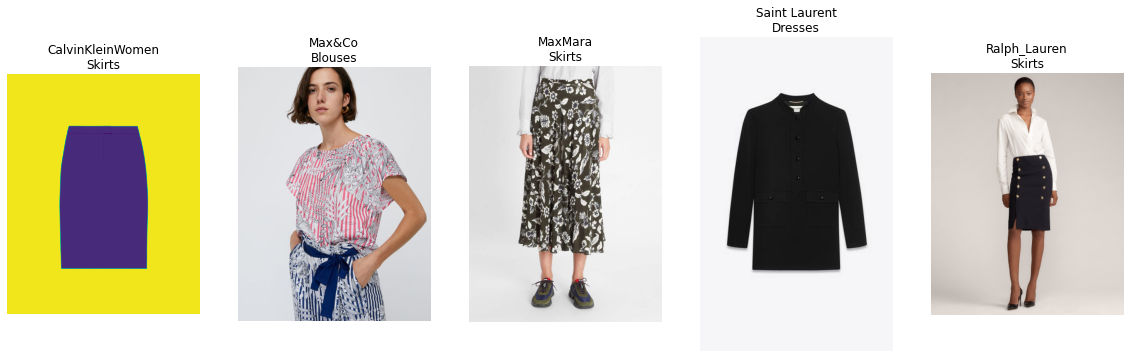

In [105]:
#Print Selection of Recommended Items
print_recommended_items(recommend_df)

## Compare User Similarity

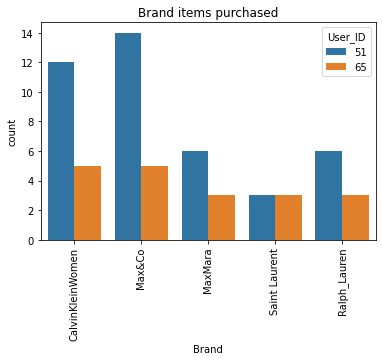

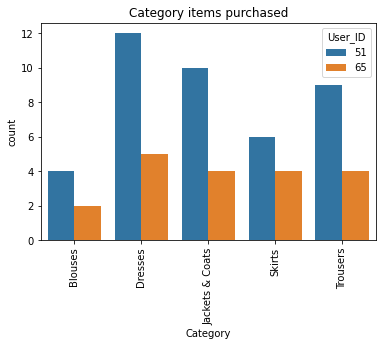

In [106]:
#Plot shop profiles
subset = user_df[user_df['User_ID'].isin(user_list)]
for item in ['Brand', 'Category']:
    sns.countplot(data = subset, x = item, hue = 'User_ID')
    plt.title(f'{item} items purchased')
    plt.xticks(rotation = 90)
    plt.show()

User purchased items
Blouses


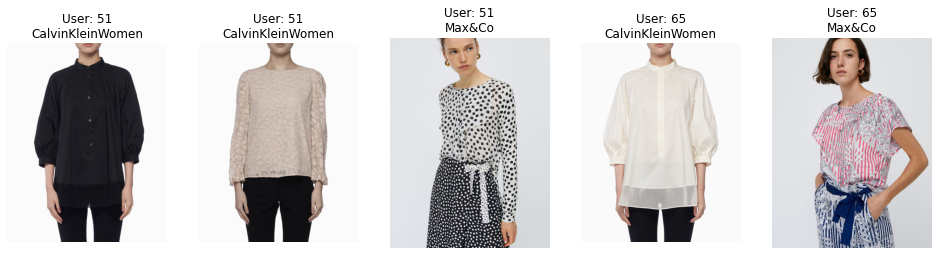

Dresses


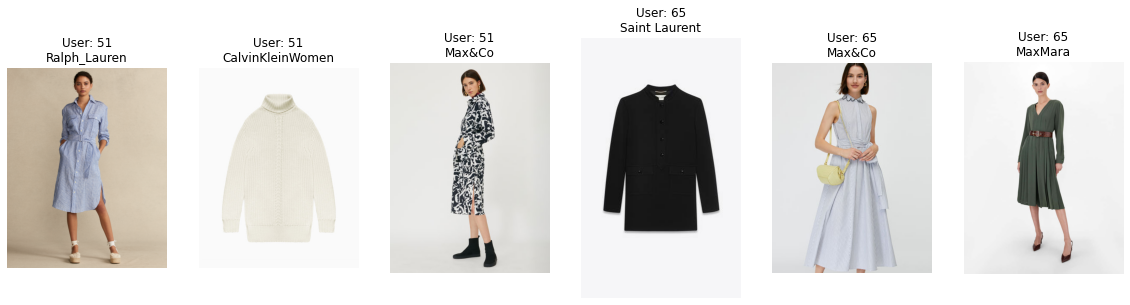

Jackets & Coats


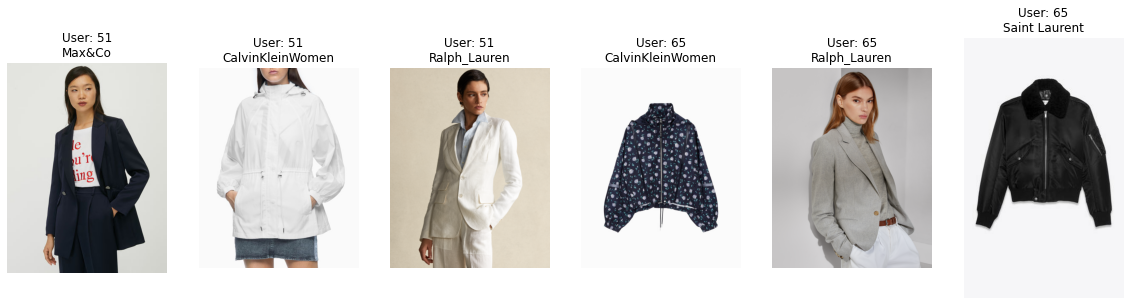

Skirts


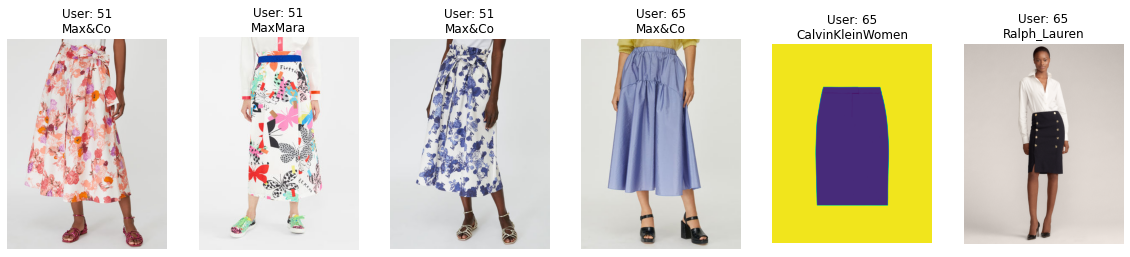

Trousers


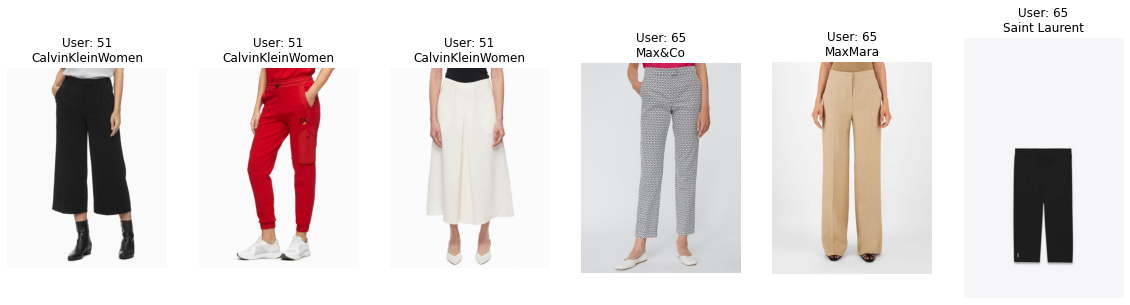

In [107]:
#Define Parameters
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36'}
n_items = 3
#Run Function
print('User purchased items')
print_user_images(user_list, n_items, user_df, headers)